# Sparkify Project Workspace - Part I: look for Features
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

### assigned Link 
....to [Blog](https://ubiquarum66.github.io/Udacity_Sparkify_Project_Blog/) I will try to interprete the findings)

In [46]:
# import libraries
from pyspark.sql import SparkSession
#from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.types import DateType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split
from pyspark.sql.functions import udf,count,when,isnan,regexp_replace,countDistinct,month,from_unixtime,to_timestamp,lead,datediff,mean


In [10]:
import datetime
import pyspark.sql.functions as F
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [11]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Wrangling Data") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [12]:
#path = "data/sparkify_log_small.json"
path = "./mini_sparkify_event_data.json"
user_log = spark.read.json(path)

In [15]:

#get number of entries in dataset
print(user_log.count())
# thanks stackoverflow: how to check for null and nans....
pddf =user_log.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in user_log.columns]).toPandas()
pddf.head()



286500


,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,58392,0,8346,8346,0,8346,58392,0,8346,0,0,8346,0,58392,0,0,8346,0


### A lot of null elements

... that reflect the fact, that different page events might use different subsets of the columns, and thus not all have to be set in all circumstances.

It is good to know, that the two essential informations for the system user interaction, the * userid and the sessionid, are without null values *.

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

### Let's call it most general information:


In [17]:
print(user_log.count())
user_log.printSchema();

#change to pandas as the table looks better :)
user_log.describe().toPandas().head(10)

286500
root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



,summary,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,count,228108,286500,278154,278154,286500,278154,228108,286500,278154,286500,286500,278154,286500,228108,286500,286500,278154,286500
1,mean,551.0852017937219,None,None,None,114.41421291448516,None,249.1171819778458,None,None,None,None,1.5353588340844272E12,1041.526554973822,Infinity,210.05459685863875,1.5409568898104834E12,None,59682.02278593872
2,stddev,1217.7693079161374,None,None,None,129.76726201140994,None,99.23517921058361,None,None,None,None,3.291321616327586E9,726.7762634630741,NaN,31.50507848842214,1.5075439608226302E9,None,109091.9499991047
3,min,!!!,Cancelled,Adelaida,F,0,Adams,0.78322,free,"Albany, OR",GET,About,1521380675000,1,ÃÂg ÃÂtti GrÃÂ¡a ÃÂsku,200,1538352117000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10)...",
4,max,ÃÂlafur Arnalds,Logged Out,Zyonna,M,1321,Wright,3024.66567,paid,"Winston-Salem, NC",PUT,Upgrade,1543247354000,2474,ÃÂau hafa sloppiÃÂ° undan ÃÂ¾unga myrkursins,404,1543799476000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,99


### First Findings 

First notes: due to the length of the integers I guess time ts to be in ms.

### Detailed investigation 

...into the contents of the columns, either seeing their length or their set of possible values



In [33]:
print(len([i.artist for i in user_log.select('artist').distinct().collect()]))
print([i.auth for i in user_log.select('auth').distinct().collect()])
#[i.firstName for i in user_log.select('firstName').distinct().collect()]
print([i.gender for i in user_log.select('gender').distinct().collect()])
#[i.itemInSession for i in user_log.select('itemInSession').distinct().collect()]
#[i.lastName for i in user_log.select('lastName').distinct().collect()]
#[i.length for i in user_log.select('length').distinct().collect()]
print([i.level for i in user_log.select('level').distinct().collect()])
#[i.location for i in user_log.select('location').distinct().collect()]
#[i.method for i in user_log.select('method').distinct().collect()]
print([i.page for i in user_log.select('page').distinct().collect()])
#[i.registration for i in user_log.select('registration').distinct().collect()]
#[i.sessionId for i in user_log.select('sessionId').distinct().collect()]
#[i.song for i in user_log.select('song').distinct().collect()]
print([i.status for i in user_log.select('status').distinct().collect()])
#[i.ts for i in user_log.select('ts').distinct().collect()]
#[i.userAgent for i in user_log.select('userAgent').distinct().collect()]
#[i.userId for i in user_log.select('userId').distinct().collect()]


17656
['Logged Out', 'Cancelled', 'Guest', 'Logged In']
['F', None, 'M']
['free', 'paid']
['Cancel', 'Submit Downgrade', 'Thumbs Down', 'Home', 'Downgrade', 'Roll Advert', 'Logout', 'Save Settings', 'Cancellation Confirmation', 'About', 'Submit Registration', 'Settings', 'Login', 'Register', 'Add to Playlist', 'Add Friend', 'NextSong', 'Thumbs Up', 'Help', 'Upgrade', 'Error', 'Submit Upgrade']
[307, 404, 200]


In [27]:
user_log.select( 'userID').distinct().sort('userid').show()

+------+
|userID|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



### not so important HTTP information....

In [32]:
#df = user_log.toPandas()
#df.to_csv('./mini_sparkify_event_data_as_csv.csv')
#user_log.printSchema();
#[i.auth for i in user_log.select('auth').distinct().collect()]
#print('gender:');[i.gender for i in user_log.select('gender').distinct().collect()]
#print('page:');[i.page for i in user_log.select('page').distinct().collect()]
[i.method for i in user_log.select('method').distinct().collect()]
#[i.userAgent for i in user_log.select('userAgent').distinct().collect()]
#[i.registration for i in user_log.select('registration').distinct().collect()]


['PUT', 'GET']

### Summarize:

+ one userID is questionable at least and will be imputed: the empty string
+ the page seems to show the type of interaction, and I use 'Submit Downgrade' as a churn event signal
+ the transition from paid to free with this event will be shown later

### check again and clean Data

In [38]:
#remove user ids which are empty strings
user_log = user_log.filter(user_log["userId"] != "")
print(user_log.filter(user_log["userID"] == "").count())

#checking how many sessionIds are missimng
user_log.filter(user_log["sessionId"] != "").count()

0


0

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [37]:
#remove user ids which are empty strings
user_log = user_log.filter(user_log["userId"] != "")
print(user_log.filter(user_log["userID"] == "").count())

#checking how many sessionIds are missimng
user_log.filter(user_log["sessionId"] != "").count()

0


0

### Churn Column

If as expected by the EDA so far, the leaving of the service is signalled with the 'Submit Downgrade' Event, the
strategy of "Data Wrangling with Data Frames# is reused: 

+ flag the event and
+ accumulate on this column to get the churn status over a 
+ time sorted window of userid's

In [41]:
flag_downgrade_event = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())

user_log = user_log.withColumn("downgraded", flag_downgrade_event("page"))

# now we have for each timestamp sorted user a delta peak where the downgrade took place

from pyspark.sql import Window

windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)

user_log = user_log.withColumn("churn", Fsum("downgraded").over(windowval))

## in the mini dataset, this user is known to churn, thus this is a test case.
user_log.select(["userId", "firstname", "ts", "page", "level", "churn"]).where(user_log.userId == "109").sort("ts").collect()


[Row(userId='109', firstname='Casey', ts=1538888285000, page='NextSong', level='free', churn=1),
 Row(userId='109', firstname='Casey', ts=1538888359000, page='Upgrade', level='free', churn=1),
 Row(userId='109', firstname='Casey', ts=1538888603000, page='NextSong', level='free', churn=1),
 Row(userId='109', firstname='Casey', ts=1538888668000, page='Roll Advert', level='free', churn=1),
 Row(userId='109', firstname='Casey', ts=1538888764000, page='NextSong', level='free', churn=1),
 Row(userId='109', firstname='Casey', ts=1538889198000, page='NextSong', level='free', churn=1),
 Row(userId='109', firstname='Casey', ts=1538889408000, page='NextSong', level='free', churn=1),
 Row(userId='109', firstname='Casey', ts=1538889645000, page='NextSong', level='free', churn=1),
 Row(userId='109', firstname='Casey', ts=1538889854000, page='NextSong', level='free', churn=1),
 Row(userId='109', firstname='Casey', ts=1538889906000, page='Settings', level='free', churn=1),
 Row(userId='109', firstname

### As time plays a crucial role in this interaction, some derivations

In [47]:
get_time = udf(lambda x: pd.Timestamp(x / 1000.0,unit='s').strftime("%Y-%m-%d %H:%M:%S"))
user_log = user_log.withColumn("time", get_time(user_log.ts)).withColumn('registration_time',get_time(user_log.registration))
user_log = user_log.withColumn('date', from_unixtime(col('ts')/1000).cast(DateType()))
user_log = user_log.withColumn('month', month("time").alias('month'))
user_log.head()

Row(artist=None, auth='Logged In', firstName='Darianna', gender='F', itemInSession=34, lastName='Carpenter', length=None, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='Logout', registration=1538016340000, sessionId=187, song=None, status=307, ts=1542823952000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', downgraded=0, churn=0, time='2018-11-21 18:12:32', registration_time='2018-09-27 02:45:40', date=datetime.date(2018, 11, 21), month=11)

### now let's build a collection of Features 

existing categorical columns (to be recoded later)... and check their relation to the churning behaviour:

In [56]:

pdg = user_log.select(["userId", 'gender', "churn"]).toPandas()
pdl = user_log.select(["userId", 'level', "churn"]).toPandas()
pdd = user_log.select(["userId", 'date', "churn"]).toPandas()

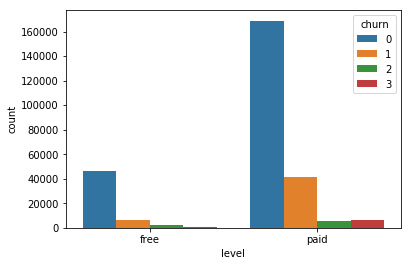

In [57]:
import seaborn as sns
sns.countplot(x='level', hue="churn", data=pdl);


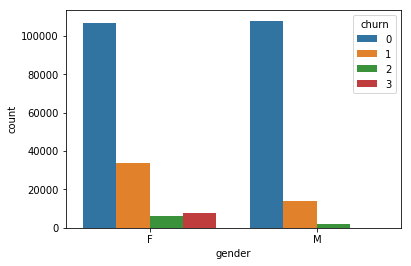

In [58]:

sns.countplot(x='gender', hue="churn", data=pdg);


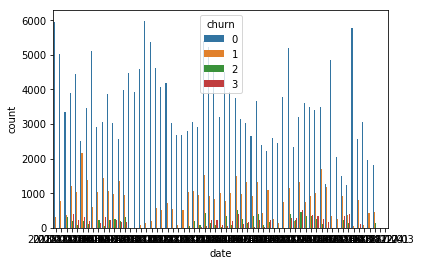

In [59]:


sns.countplot(x='date', hue="churn", data=pdd);

+-------+-------------------+
|summary|               time|
+-------+-------------------+
|  count|             278154|
|   mean|               null|
| stddev|               null|
|    min|2018-10-01 00:01:57|
|    max|2018-12-03 01:11:16|
+-------+-------------------+



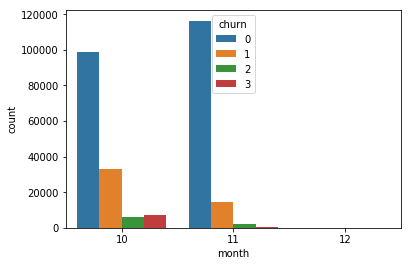

In [61]:

pdm = user_log.select(["userId", 'month', "churn"]).toPandas()
sns.countplot(x='month', hue="churn", data=pdm);
user_log.select('time').describe().show()

### First interpretations see in the BLOG Report 

[Here](https://ubiquarum66.github.io/Udacity_Sparkify_Project_Blog/) I will try to interprete the findings.

### Putting it together

+ ceate one churn feature dataframe ... later repeated in the fit script notebook

In [99]:
#The main component is churn and user, and as it shows above, that some guys 
#churn return more than 3 times, we just take the max, and do ignore the on-off details in between

churningusers = user_log.groupBy("userId").max("churn").withColumnRenamed("max(churn)", "churn")
churningusers.select(["userId", "churn"])

DataFrame[userId: string, churn: bigint]

### include further easy obtainable ones... 

perhaps to be used...first define them, then rename them to be more concise...

Finally, join all of them together to the feature set...


In [100]:
songcount = user_log.groupby("userId").agg(countDistinct("song"))
artistdiversity = user_log.groupby("userId").agg(countDistinct("artist"))
sumoflength=user_log.groupby("userId").agg({"length" : "sum"})
visitfrequency = user_log.groupby("userId").count()


In [101]:
songcount = songcount.withColumnRenamed("count(DISTINCT song)", "songcount")
artistdiversity = artistdiversity.withColumnRenamed("count(DISTINCT artist)", "artistdiversity")
sumoflength=sumoflength.withColumnRenamed("sum(length)","sumoflength")
visitfrequency = visitfrequency.withColumnRenamed("count", "visitfrequency")


In [102]:

first_interaction =  user_log.groupBy('userId').agg(min('ts').alias('first_interaction'))
last_interaction =  user_log.groupBy('userId').agg(max('ts').alias('last_interaction'))
mean_interaction =  user_log.groupBy('userId').agg(mean('ts').alias('mean_interaction'))

In [103]:
# again the userid with the known churning as a test

churningusers  = churningusers.join(artistdiversity,["userId"])
churningusers  = churningusers.join(visitfrequency,["userId"])
churningusers  = churningusers.join(songcount,["userId"])
churningusers  = churningusers.join(sumoflength,["userId"])
churningusers  = churningusers.join(first_interaction,["userId"])
churningusers  = churningusers.join(last_interaction,["userId"])
churningusers  = churningusers.join(mean_interaction,["userId"])

churningusers.where(user_log.userId==109).head()

Row(userId='109', churn=1, artistdiversity=580, visitfrequency=861, songcount=689, sumoflength=178960.94166000007, first_interaction=1538888285000, last_interaction=1542371584000, mean_interaction=1540568203773.519)

In [104]:
churningusers = churningusers.withColumn('lastedinteraction', churningusers['last_interaction']-churningusers['first_interaction'])


In [105]:

def doMyPlot(dfin, colname):
    dfinpd = dfin.toPandas()
    sns.boxplot(x="churn", y=colname, data=dfinpd);
    plt.show()

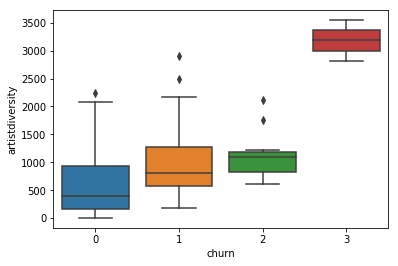

In [106]:
doMyPlot(churningusers,'artistdiversity')

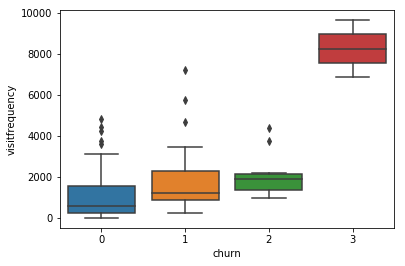

In [107]:

doMyPlot(churningusers,'visitfrequency')

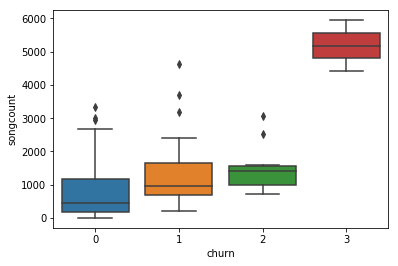

In [108]:

doMyPlot(churningusers,'songcount')

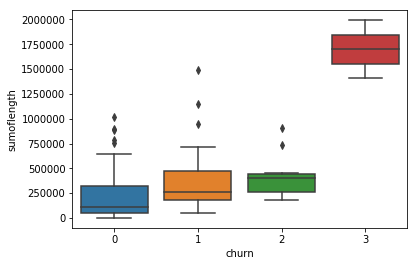

In [109]:

doMyPlot(churningusers,'sumoflength')

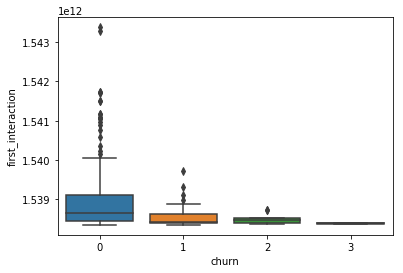

In [110]:

doMyPlot(churningusers,'first_interaction')

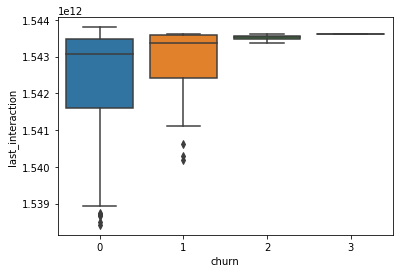

In [111]:

doMyPlot(churningusers,'last_interaction')


In [112]:
churningusers.printSchema()

root
 |-- userId: string (nullable = true)
 |-- churn: long (nullable = true)
 |-- artistdiversity: long (nullable = false)
 |-- visitfrequency: long (nullable = false)
 |-- songcount: long (nullable = false)
 |-- sumoflength: double (nullable = true)
 |-- first_interaction: long (nullable = true)
 |-- last_interaction: long (nullable = true)
 |-- mean_interaction: double (nullable = true)
 |-- lastedinteraction: long (nullable = true)



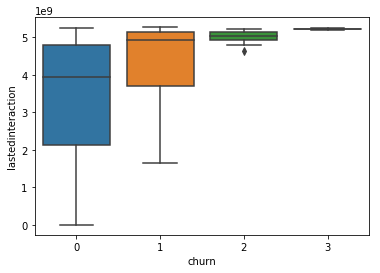

In [113]:

doMyPlot(churningusers,'lastedinteraction')

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

### Modeling is sourced out to another script without interactive elements

[Here](https://github.com/ubiquarum66/UdacityProjectSparkify) you can find both of this notebooks!

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.